# Analysis of E. melliodora drought data

data collected 2016

Looking for effect between wateringtreatments and/or populations or maternal lines.

In [1]:
options(jupyter.plot_mimetypes = "image/png")

# Data 

### read in raw data 

In [2]:
#excel sheet of measurements from Abby exported as a csv (changed position to row & column)
infile_path="/home/megan/Desktop/emel_lb1234/emel_chamber_analysis/drought/data" #path to infile
infile="EmelliodoraDrought20.10.16.csv" #infile
indata=read.delim(paste(infile_path, infile, sep="/"),sep=",", strip.white=T) #read in infile
#head(indata)

### clean up data

In [3]:
indata[indata=="."]=NA #replace . used for dead with NA

#remove extra columns
trash=names(indata) %in% c("Line","Growth.Measure.Date","Growth.Measure.Number","Growth.Measure.Plant.Height.....cm",
                           "Growth.Measure.Leaf.Number","Growth.Measure.Longest.Leaf.Length...cm",
                           "Leaf.Measure.Date","Leaf.Sample.Number",
                           "Leaf.Measure.Spad..1","Leaf.Measure.Spad..2","Leaf.Measure.Spad.Mean",
                           "Leaf.Measure.Area..1..cm.","Leaf.Measure.Area..2..cm.","Leaf.Measure.Area.Mean..cm.",
                           "Leaf.Measure.Perimeter.cm","Leaf.Measure.Perimeter..1.cm",
                           "Leaf.Measure.Perimeter..2.cm","Leaf.Measure.Perimeter.Mean.......cm",
                           "Leaf.Measure.Length..1..cm","Leaf.Measure.Length..2..cm","Leaf.Measure.Length.Mean......cm", 
                           "Leaf.Measure.Width..1...cm","Leaf.Measure.Width..2...cm","Leaf.Measure.Width..Mean.....cm",
                           "Leaf.Measure.Dry.Weight..1...g","Leaf.Measure.Dry.Weight..2...g",
                           "Leaf.Measure.Dry.Weight.Mean........g",
                           "Leaf.Measure.SLA..leaf.area.cm....dry.leaf.weight.g.",
                            "Notes")
indata <- indata[!trash]

#fix some names
colnames(indata)[names(indata)=="Position.Column"]="row"
colnames(indata)[names(indata)=="Position.Row"]="column"
colnames(indata)[names(indata)=="Leaf.Measure.Number"]="leaf.measurement"
colnames(indata)[names(indata)=="Leaf.Measure.Porometer.mmol.m.s"]="porometer"
colnames(indata)[names(indata)=="Leaf.Measure.Spad"]="spad"
colnames(indata)[names(indata)=="Leaf.Measure.Area.....cm."]="area"
colnames(indata)[names(indata)=="Leaf.Measure.Length....cm"]="length"
colnames(indata)[names(indata)=="Leaf.MeasureWidth...cm"]="width"
colnames(indata)[names(indata)=="Leaf.Measure.Dry.Weight....g"]="weight"
colnames(indata)[names(indata)=="Position.Block"]="Block"

#fix position info so can use row/column to identify reps
indata$column[indata$column=="E"]="A"
indata$column[indata$column=="F"]="B"
indata$column[indata$column=="G"]="C"
indata$column[indata$column=="H"]="D"

#fix column so it is numeric
indata$column=as.integer(indata$column)

#reformat plant ID
indata$PlantID=paste(indata$Population,"-",indata$Mother,"-",indata$Replicate,sep="")

#convert from factors to numeric values 
indata$porometer=as.numeric(as.character(indata$porometer))
indata$spad=as.numeric(as.character(indata$spad))
indata$area=as.numeric(as.character(indata$area))
indata$weight=as.numeric(as.character(indata$weight))
indata$length=as.numeric(as.character(indata$length))
indata$width=as.numeric(as.character(indata$width))

#calc SLA
indata$sla=indata$area/indata$weight
#calc lw ratio
indata$lw=indata$length/indata$width

#determine maternal line from Population + Mother
indata["matline"]=paste(indata$Population, indata$Mother, sep="-")
indata$matline=factor(indata$matline)

trash=names(indata) %in% c("Plant.ID")
indata <- indata[!trash]

#change Drought and Water to lower case for nice plots
indata$Treatment=as.character(indata$Treatment)
indata$Treatment[indata$Treatment=="Water"]="water"
indata$Treatment[indata$Treatment=="Drought"]="drought"
indata$Treatment=as.factor(indata$Treatment)

head(indata)

,Individual.Number,Chamber,row,column,Block,Treatment,Population,Mother,Replicate,leaf.measurement,porometer,spad,area,length,width,weight,PlantID,sla,lw,matline
1,286,35,1,1,1,water,D,7,4,1:0,324.2,58.1,10.9559,6.6516,2.6165,0.1071,D-7-4,102.296,2.542175,D-7
2,149,35,1,3,1,water,11,1,15,1:0,262.9,67.9,7.5713,7.6295,1.5731,0.1127,11-1-15,67.18101,4.849978,11-1
3,204,35,2,2,1,water,T3,9,13,1:0,320.5,58.7,21.6635,9.7576,3.7656,0.1784,T3-9-13,121.4322,2.591247,T3-9
4,292,35,2,4,1,water,G,9,15,1:0,NA,NA,NA,NA,NA,NA,G-9-15,NA,NA,G-9
5,151,35,3,1,1,water,11,6,3,1:0,259.6,57,7.2844,7.5346,1.5599,0.0931,11-6-3,78.24275,4.830181,11-6
6,93,35,3,3,1,water,B,3,3,1:0,293.8,51.2,14.9752,9.0447,2.8785,0.164,B-3-3,91.3122,3.142157,B-3


In [4]:
#remove dead plants (ie no porometer at 1:0 and  ) and their pair
remove=unique(subset(indata, is.na(spad) | leaf.measurement=="1:0" & is.na(porometer))) #identify dead and remove 
remove=remove[!duplicated(remove[,1]),]                                                 #remove duplicates
indata_set=indata
for (i in 1:dim(remove)[1])                                                             #remove its pair
    {
        indata_set=subset(indata_set, row!=remove$row[i] | column!=remove$column[i])
    }
remove

#also remove strong outlier unhealthy plant row 23, col 1
indata_set=subset(indata_set, row!=23 | column!=1)

#subset for two measure times
data1=subset(indata_set, leaf.measurement=="1:0")
data2=subset(indata_set, leaf.measurement=="2:0")

dim(indata_set)
dim(data1)
dim(data2)

,Individual.Number,Chamber,row,column,Block,Treatment,Population,Mother,Replicate,leaf.measurement,porometer,spad,area,length,width,weight,PlantID,sla,lw,matline
4,292,35,2,4,1,water,G,9,15,1:0,NA,NA,NA,NA,NA,NA,G-9-15,NA,NA,G-9
55,505,36,18,2,2,water,11,9,14,1:0,NA,NA,NA,NA,NA,NA,11-9-14,NA,NA,11-9
71,358,36,16,2,2,drought,D,5,11,1:0,NA,55.5,14.4609,9.9696,2.3577,0.0955,D-5-11,151.423,4.228528,D-5
212,364,36,16,4,2,water,11,7,17,2:0,NA,NA,NA,NA,NA,NA,11-7-17,NA,NA,11-7
255,268,35,28,2,3,water,11,9,16,2:0,NA,NA,NA,NA,NA,NA,11-9-16,NA,NA,11-9
311,341,36,36,2,4,drought,D,5,6,2:0,NA,NA,NA,NA,NA,NA,D-5-6,NA,NA,D-5


[1] 292  20

[1] 146  20

[1] 146  20

## visualize data

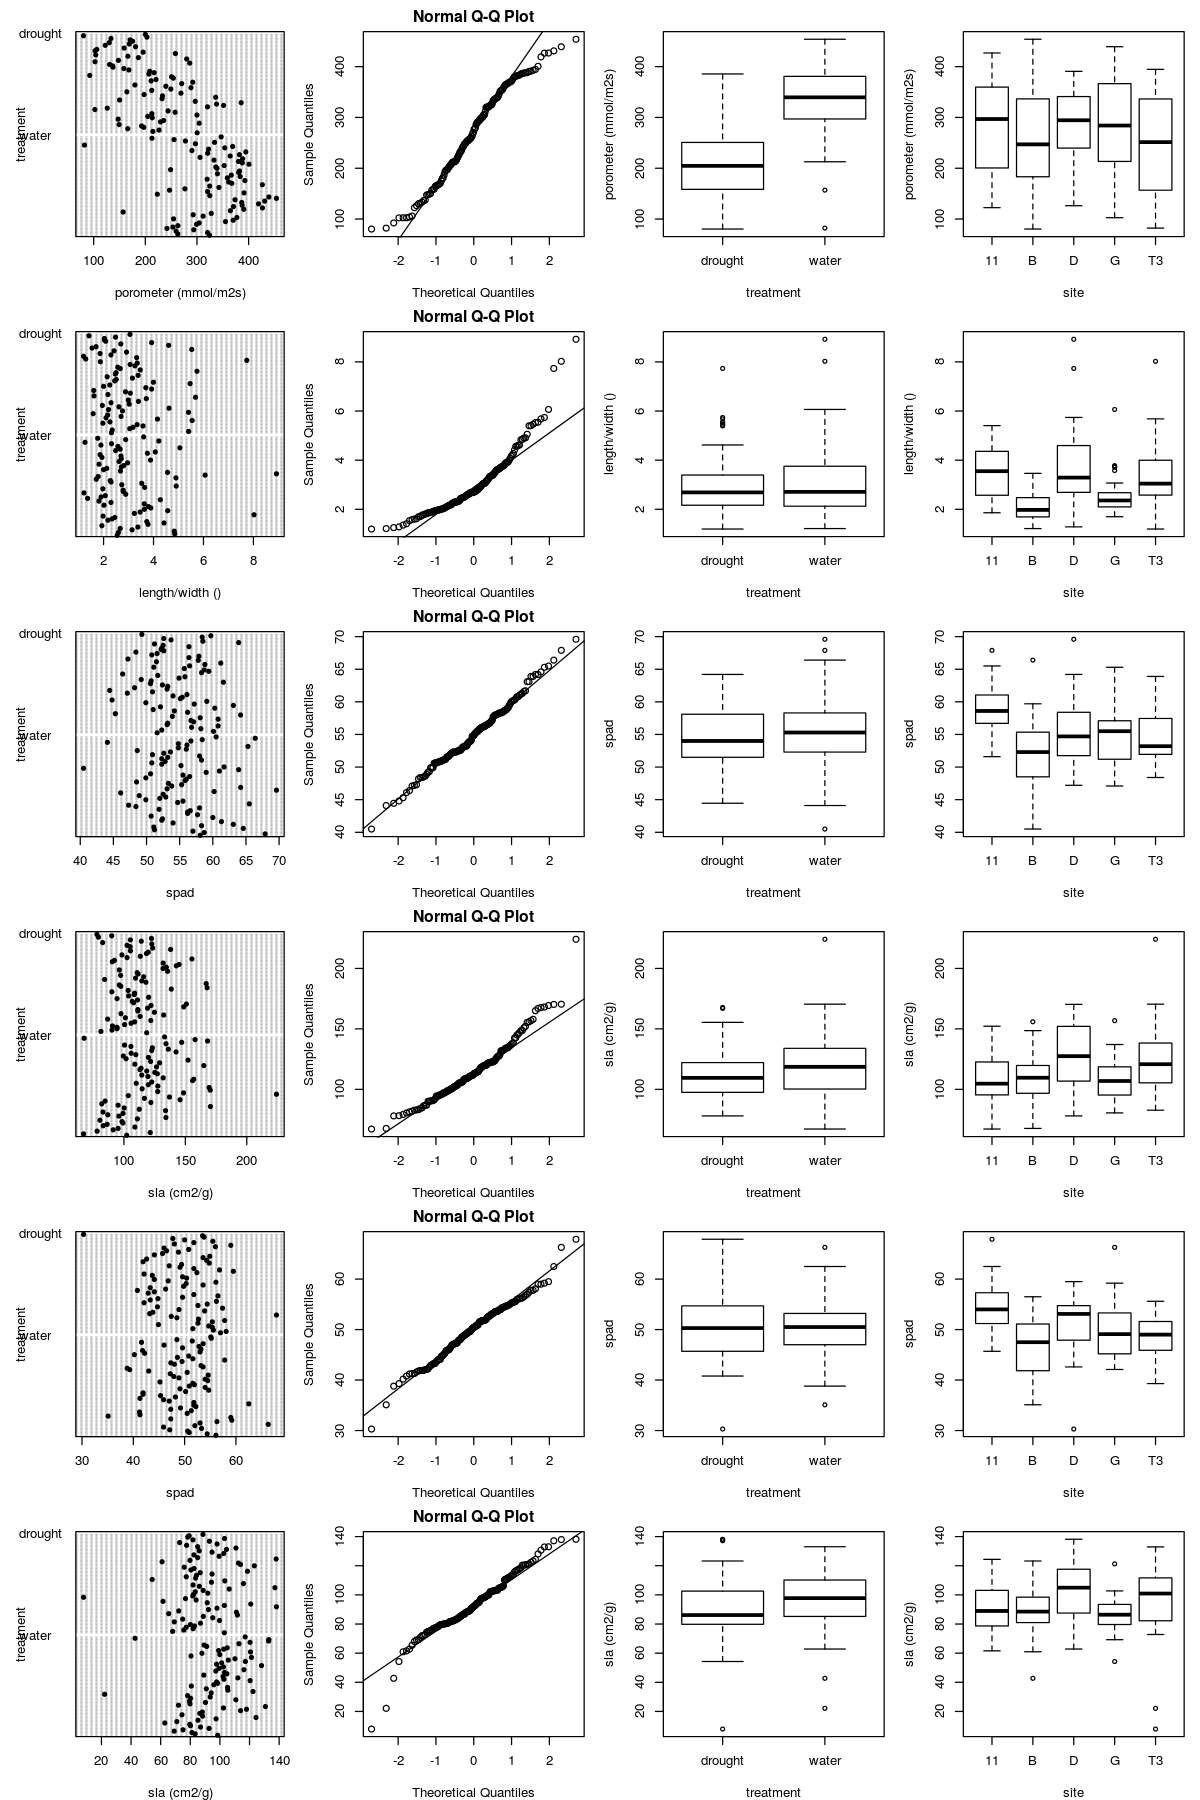

In [5]:
#dot plots, Q-Q plots, box plots
par(mfrow=c(6,4), mar=c(4,4,2,1))
options(repr.plot.width=10, repr.plot.height=15)

#porometer
dotchart(data1$porometer, groups=data1$Treatment, 
         xlab="porometer (mmol/m2s)", ylab="treatment", pch=20)
qqnorm(data1$porometer)
qqline(data1$porometer)
boxplot(porometer ~ Treatment, data=data1, xlab="treatment",ylab="porometer (mmol/m2s)")
boxplot(porometer ~ Population, data=data1, xlab="site",ylab="porometer (mmol/m2s)")

#length/width
dotchart(data1$lw, groups=data1$Treatment, 
         xlab="length/width ()", ylab="treatment", pch=20)
qqnorm(data1$lw)
qqline(data1$lw)
boxplot(lw ~ Treatment, data=data1, xlab="treatment",ylab="length/width ()")
boxplot(lw ~ Population, data=data1, xlab="site",ylab="length/width ()")

#spad1
dotchart(data1$spad, groups=data1$Treatment, 
         xlab="spad", ylab="treatment", pch=20)
qqnorm(data1$spad)
qqline(data1$spad)
boxplot(spad ~ Treatment, data=data1, xlab="treatment",ylab="spad")
boxplot(spad ~ Population, data=data1, xlab="site",ylab="spad")

#sla1
dotchart(data1$sla, groups=data1$Treatment, 
         xlab="sla (cm2/g)", ylab="treatment", pch=20)
qqnorm(data1$sla)
qqline(data1$sla)
boxplot(sla ~ Treatment, data=data1, xlab="treatment",ylab="sla (cm2/g)")
boxplot(sla ~ Population, data=data1, xlab="site",ylab="sla (cm2/g)")

#spad2
dotchart(data2$spad, groups=data2$Treatment, 
         xlab="spad", ylab="treatment", pch=20)
qqnorm(data2$spad)
qqline(data2$spad)
boxplot(spad ~ Treatment, data=data2, xlab="treatment",ylab="spad")
boxplot(spad ~ Population, data=data2, xlab="site",ylab="spad")

#sla2
dotchart(data2$sla, groups=data2$Treatment, 
         xlab="sla (cm2/g)", ylab="treatment", pch=20)
qqnorm(data2$sla)
qqline(data2$sla)
boxplot(sla ~ Treatment, data=data2, xlab="treatment",ylab="sla (cm2/g)")
boxplot(sla ~ Population, data=data2, xlab="site",ylab="sla (cm2/g)")  #plot=F to get numbers

D, T3 drier; 
B, 11 in the middle; 
G wetter; 

l:w 11,D,T3 higher; B,G lower

spad 11 is higher

sla D, T3 higher (opposite of hypothesis)

spad2 same between treatments

sla2 lower in drought (matches hypothesis)

In [6]:
#pdf of select box plots
pdf("drought_box.pdf", width=4, height=7)
par(mfrow=c(4,2), mar=c(4,4,0,0.5), oma=c(0,1,0,0))

#porometer
boxplot(porometer ~ Treatment, data=data1, ylab="")
mtext(text="stomatal conductance", side=2, cex=.75, line=4)
mtext(text=expression(paste('(mmol/(',m ^ 2, 's))'), sep=""), side=2, cex=.7, line=2.5)
boxplot(porometer ~ Population, data=data1)

#length/width
boxplot(lw ~ Treatment, data=data1, ylab="length to width ratio")
boxplot(lw ~ Population, data=data1)

#spad2
boxplot(spad ~ Treatment, data=data2, ylab="SPAD index")
boxplot(spad ~ Population, data=data2)

#sla2
boxplot(sla ~ Treatment, data=data2, xlab="treatment",ylab="")
mtext(text=expression(paste('SLA (',cm^2,'/g)',sep="")), side=2, cex=.7, line=2.5)
boxplot(sla ~ Population, data=data2, xlab="site")

dev.off()

pdf 
  2

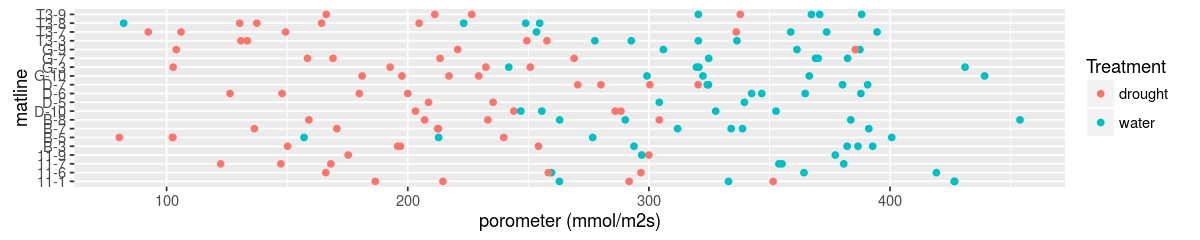

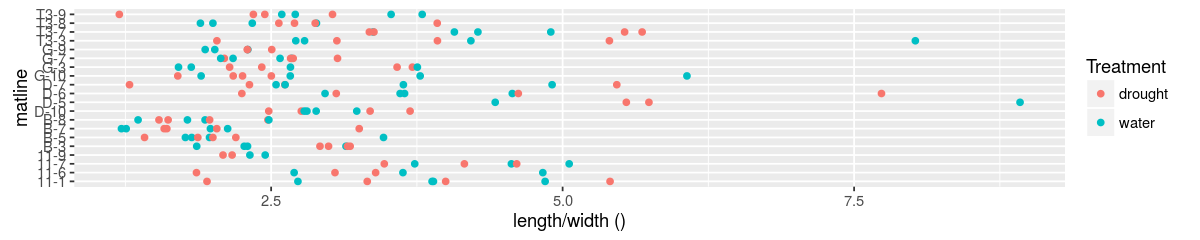

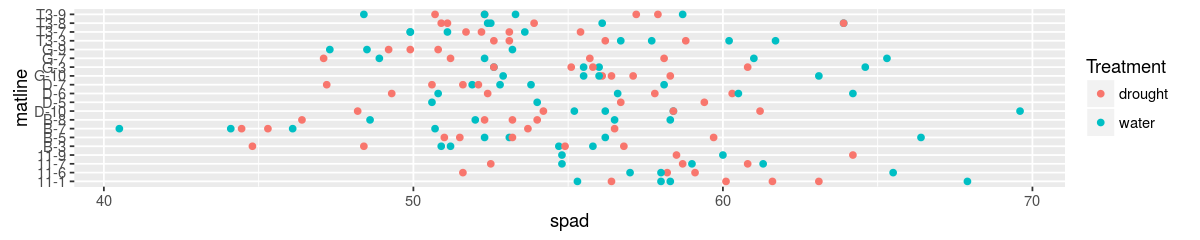

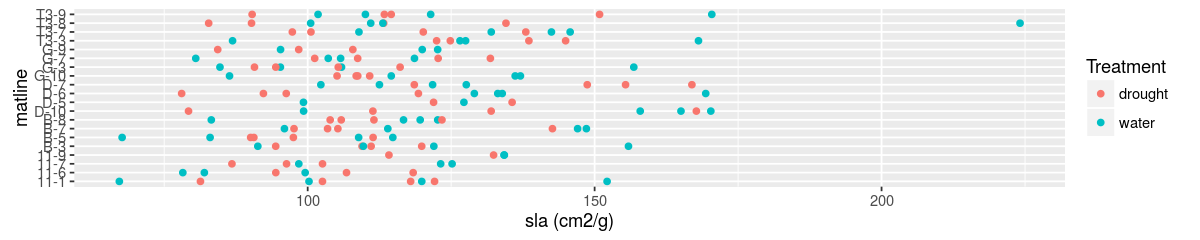

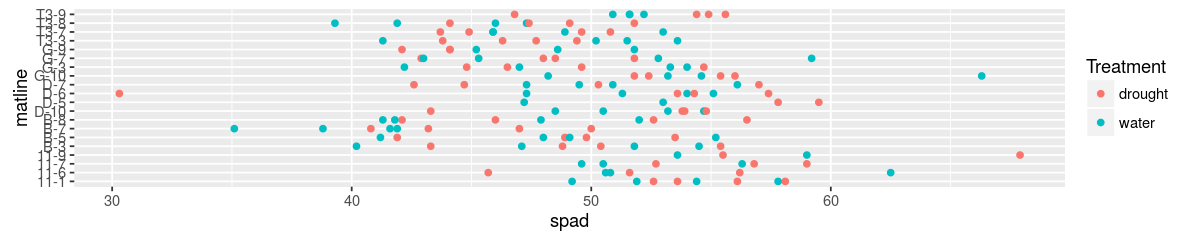

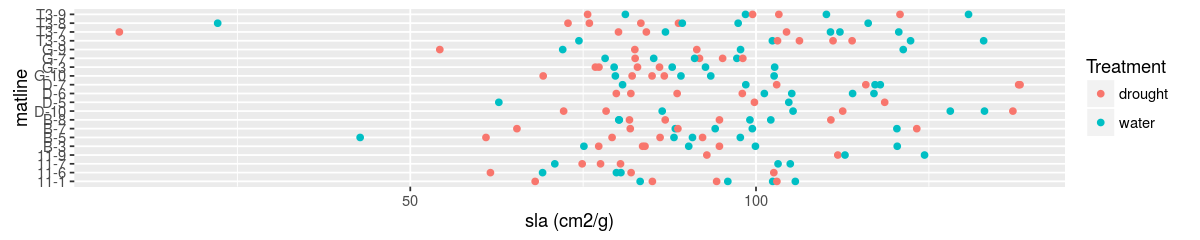

In [7]:
#colored dot plots
library(ggplot2)
options(repr.plot.width=10, repr.plot.height=2)

ggplot(data1, aes(porometer, matline, colour=Treatment)) + geom_point() + 
    xlab("porometer (mmol/m2s)")# + ggtitle("")
ggplot(data1, aes(lw, matline, colour=Treatment)) + geom_point() + 
    xlab("length/width ()")# + ggtitle("")
ggplot(data1, aes(spad, matline, colour=Treatment)) + geom_point() + 
    xlab("spad")# + ggtitle("")
ggplot(data1, aes(sla, matline, colour=Treatment)) + geom_point() + 
    xlab("sla (cm2/g)")# + ggtitle("")
ggplot(data2, aes(spad, matline, colour=Treatment)) + geom_point() + 
    xlab("spad")# + ggtitle("")
ggplot(data2, aes(sla, matline, colour=Treatment)) + geom_point() + 
    xlab("sla (cm2/g)")# + ggtitle("")

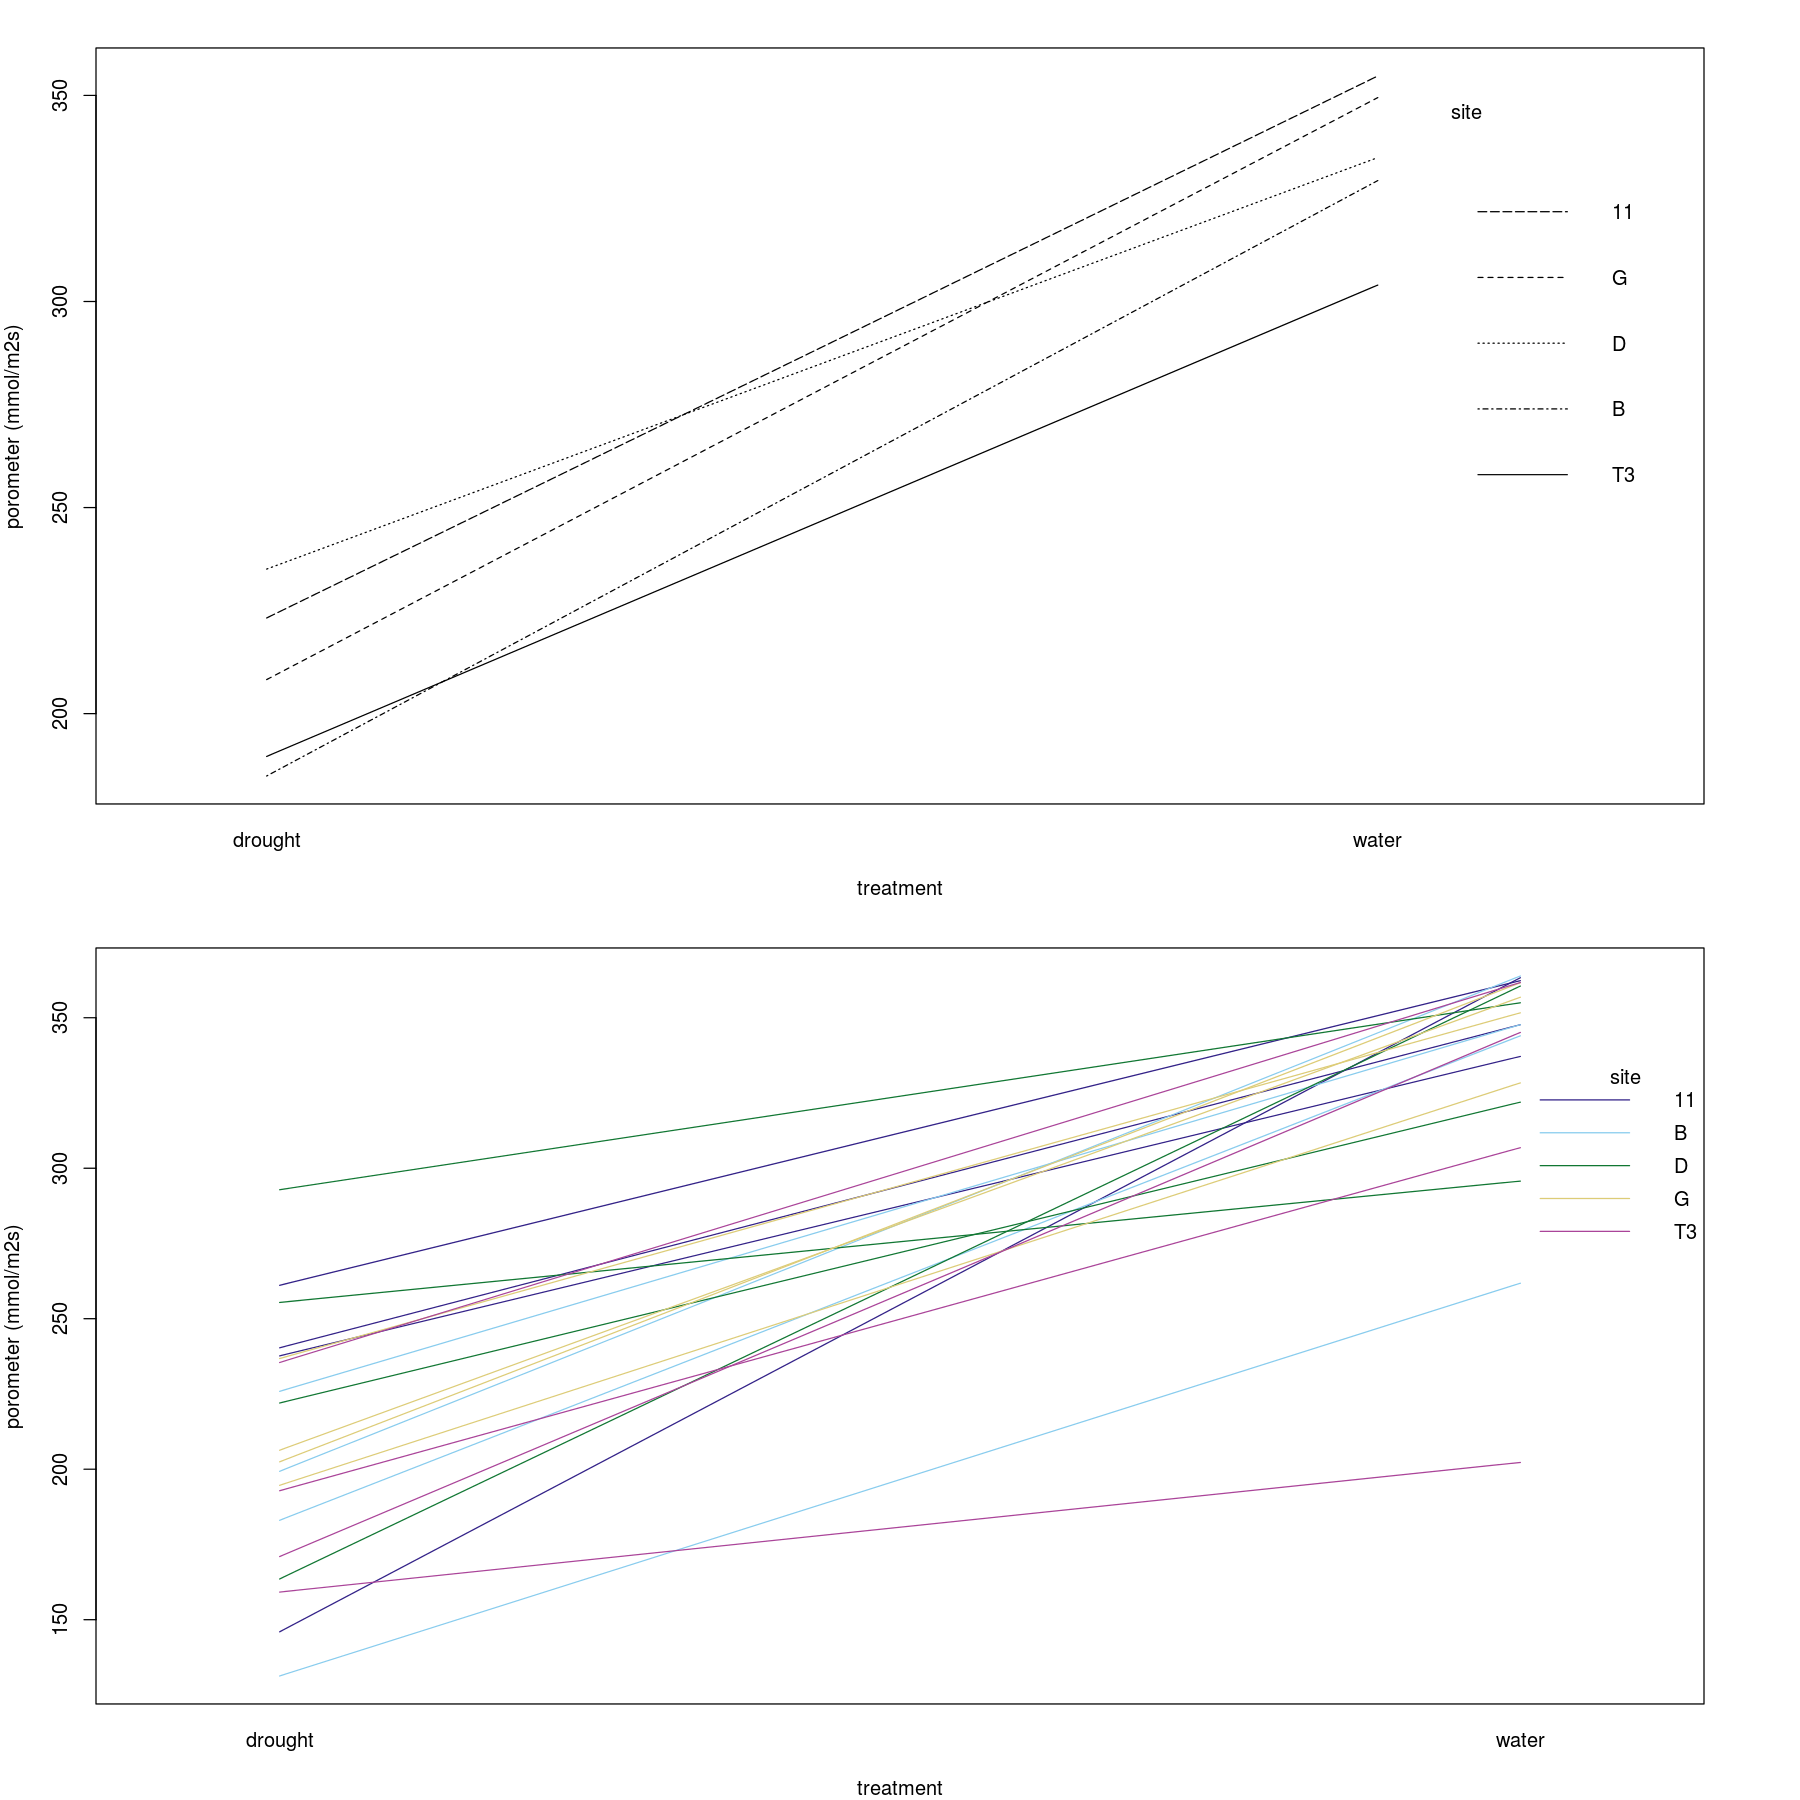

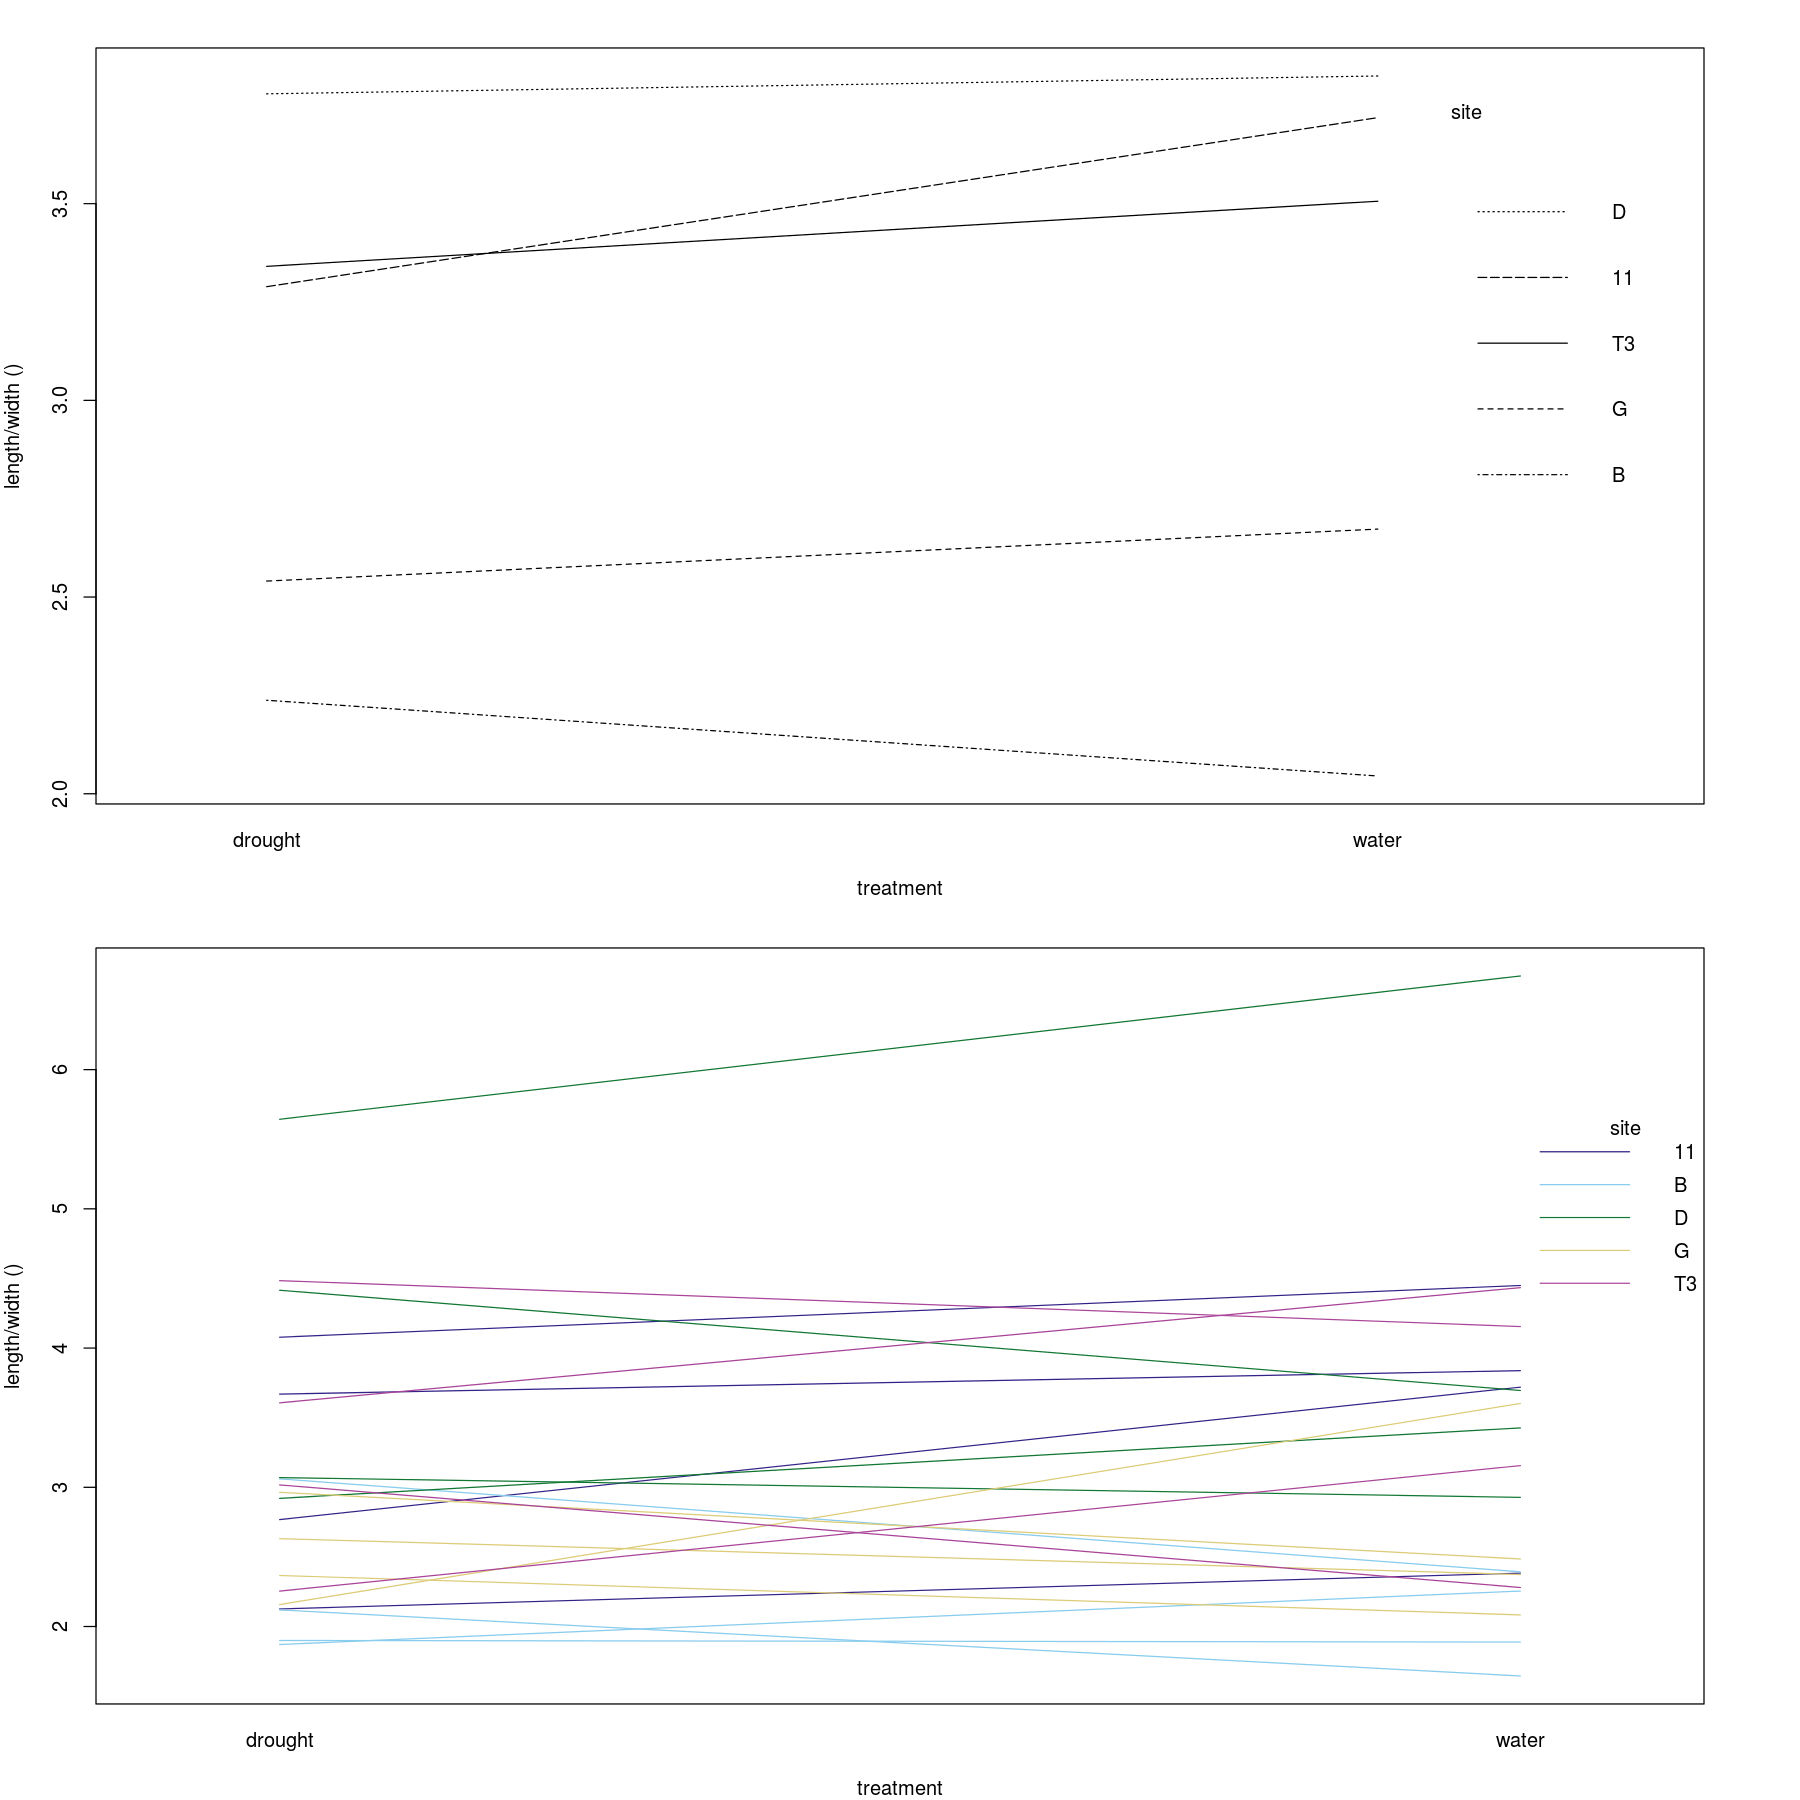

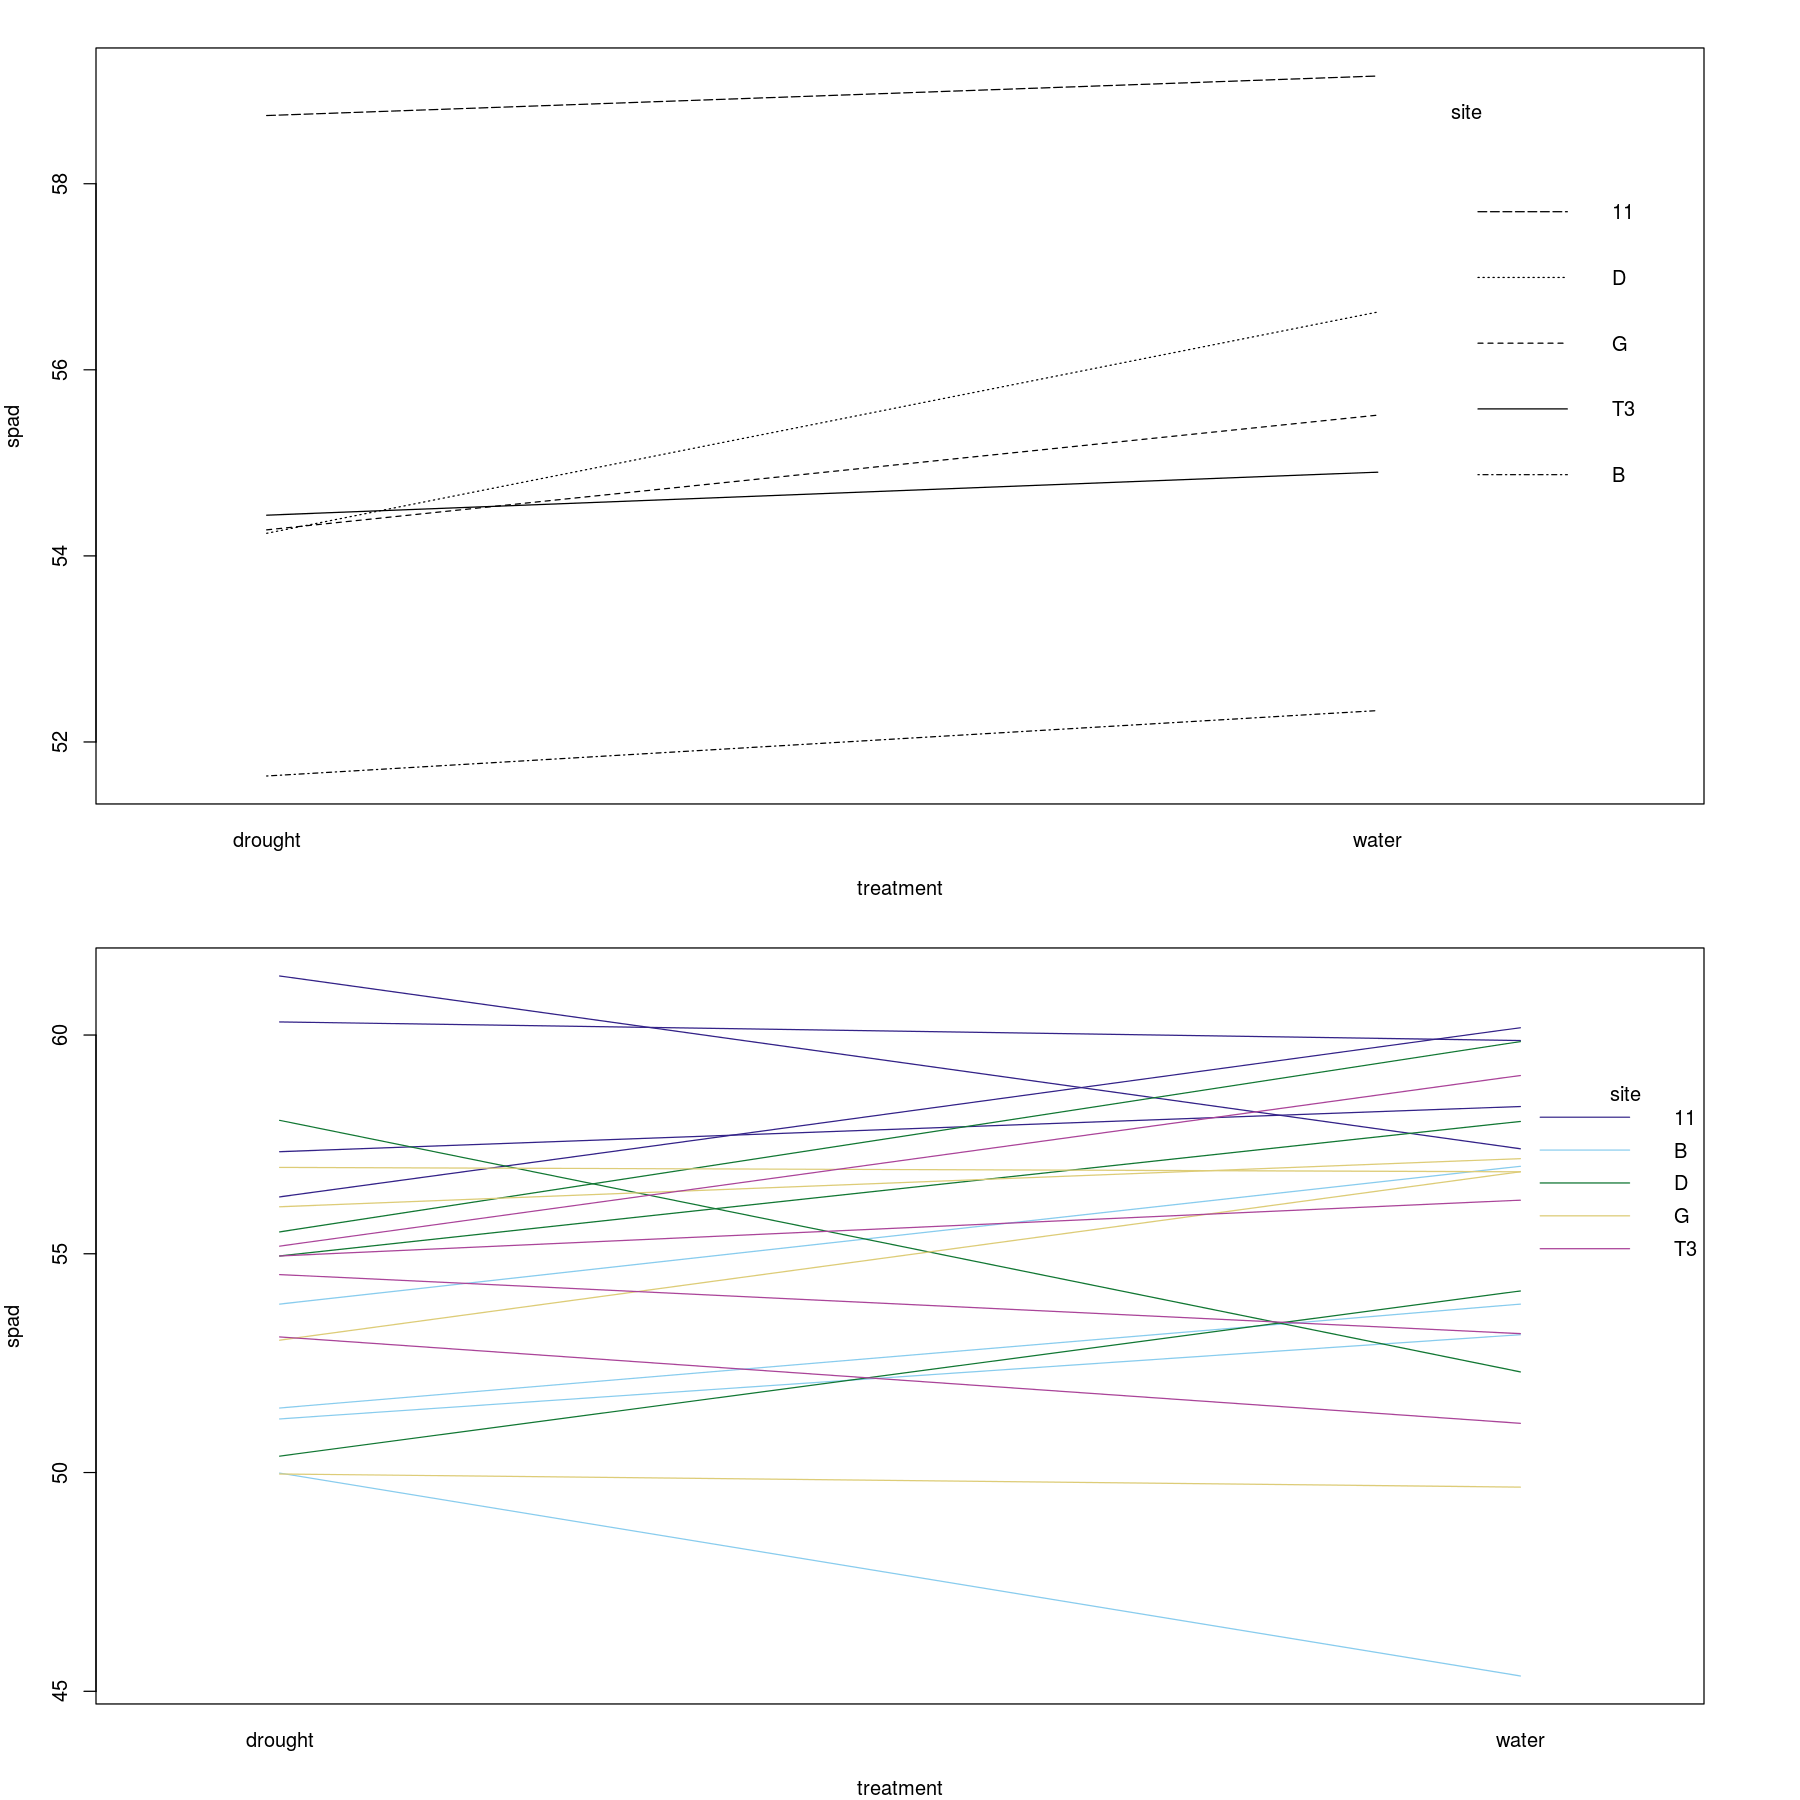

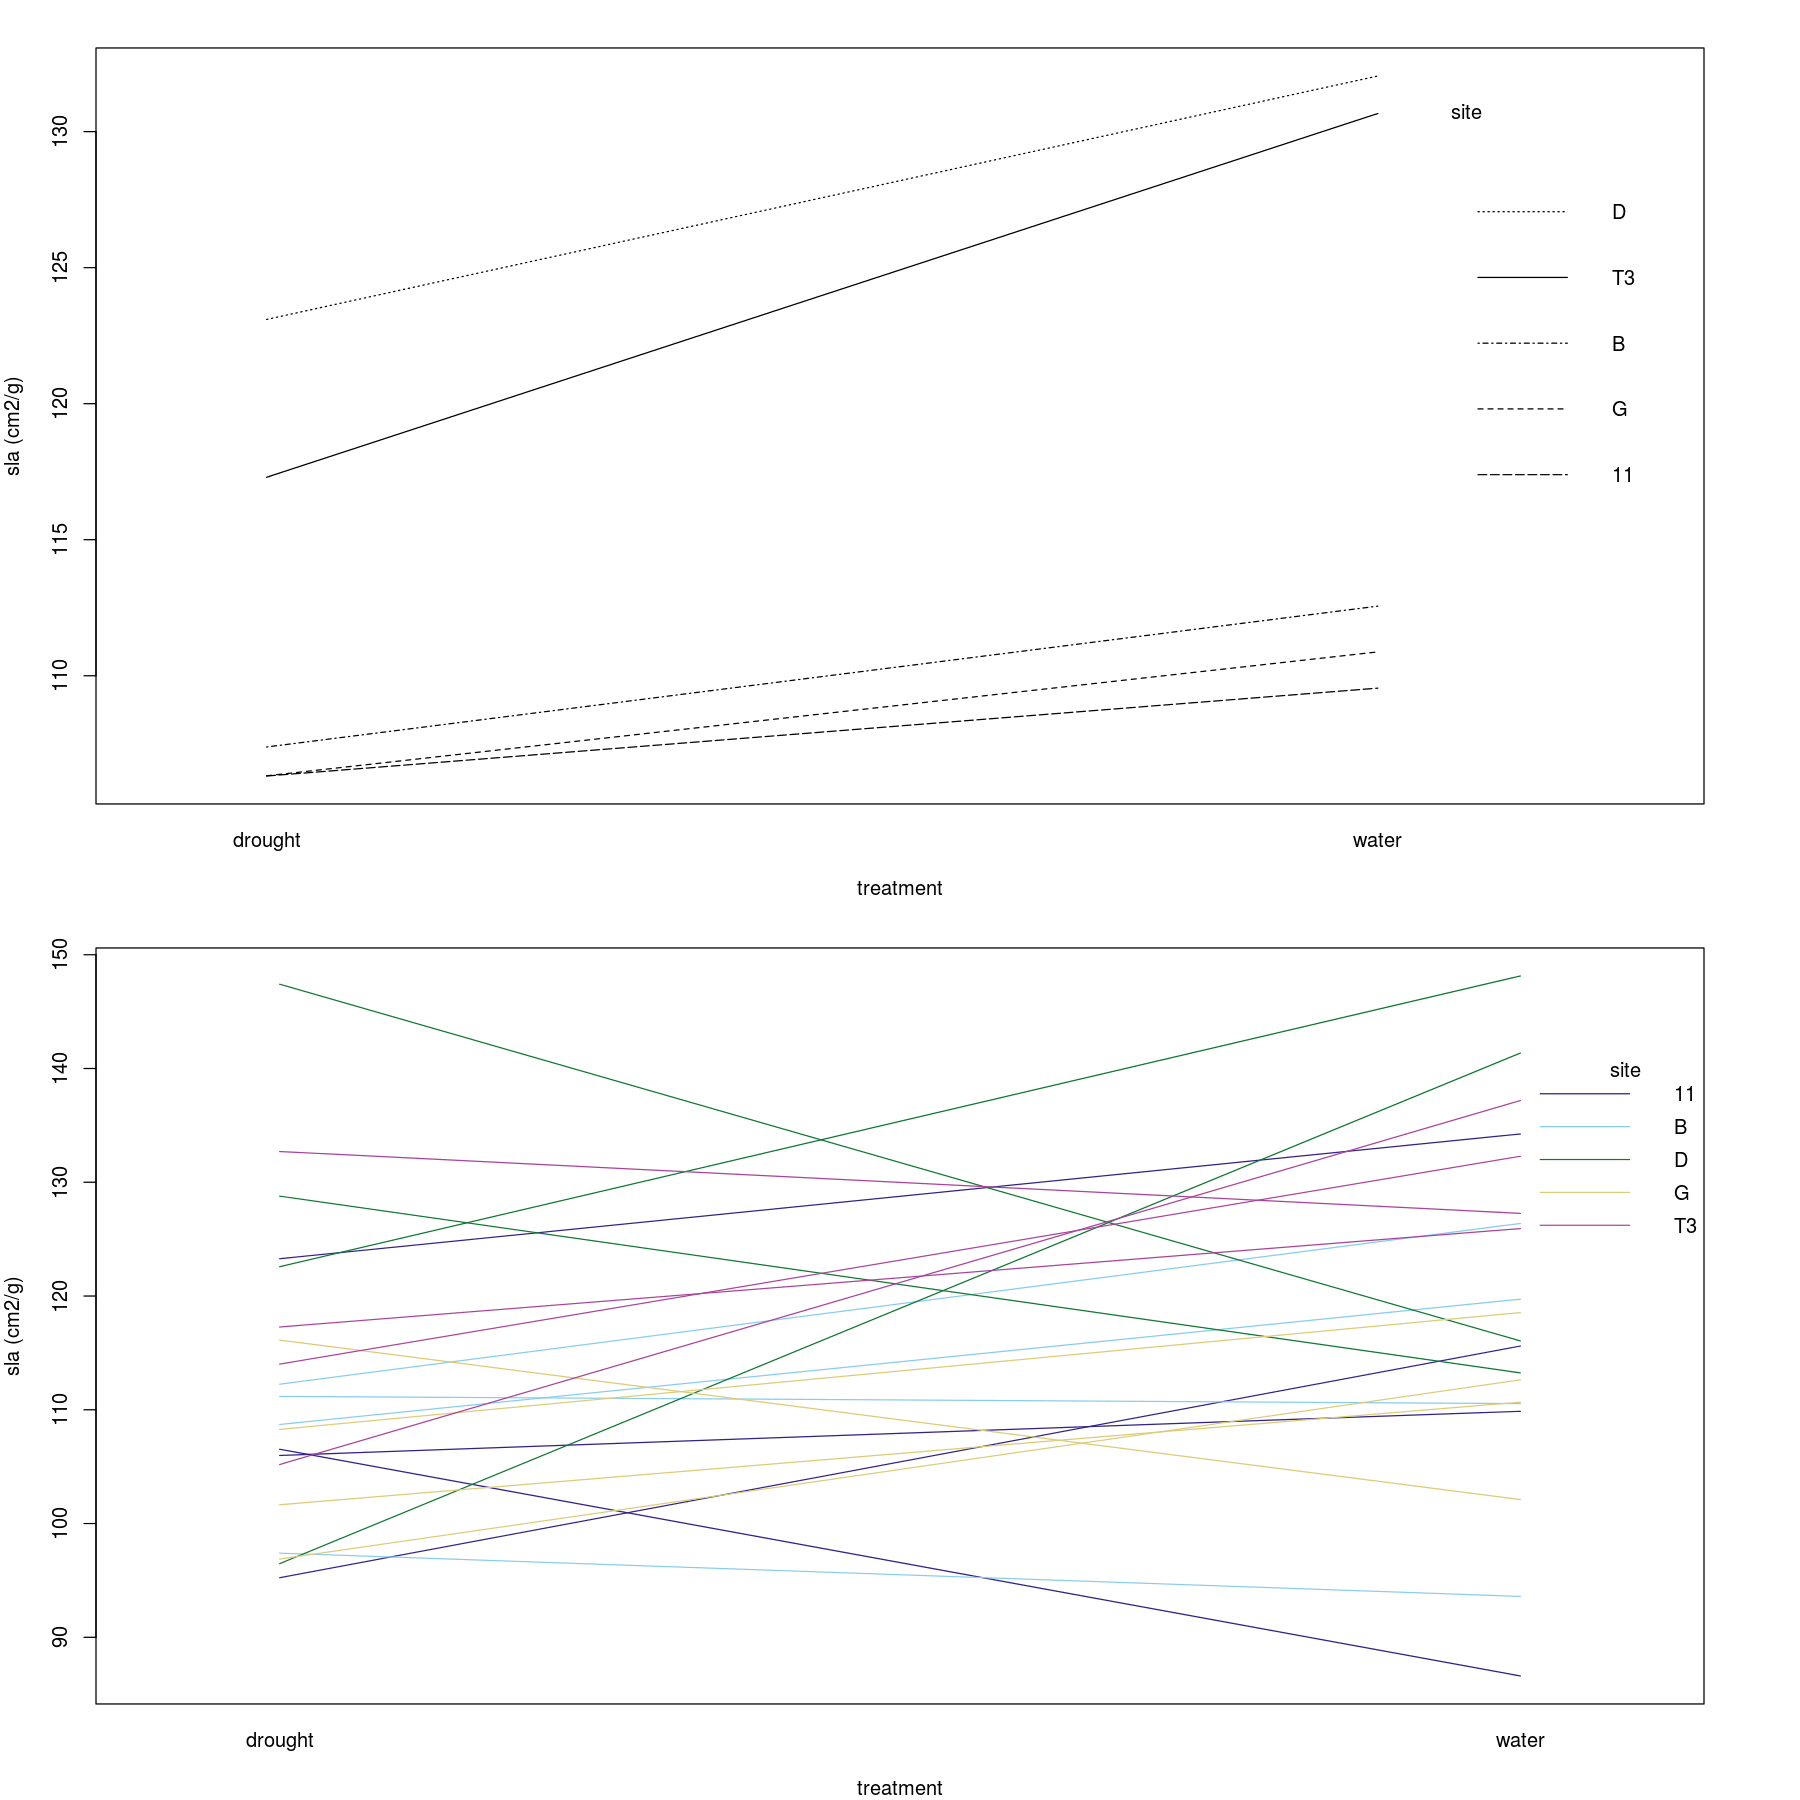

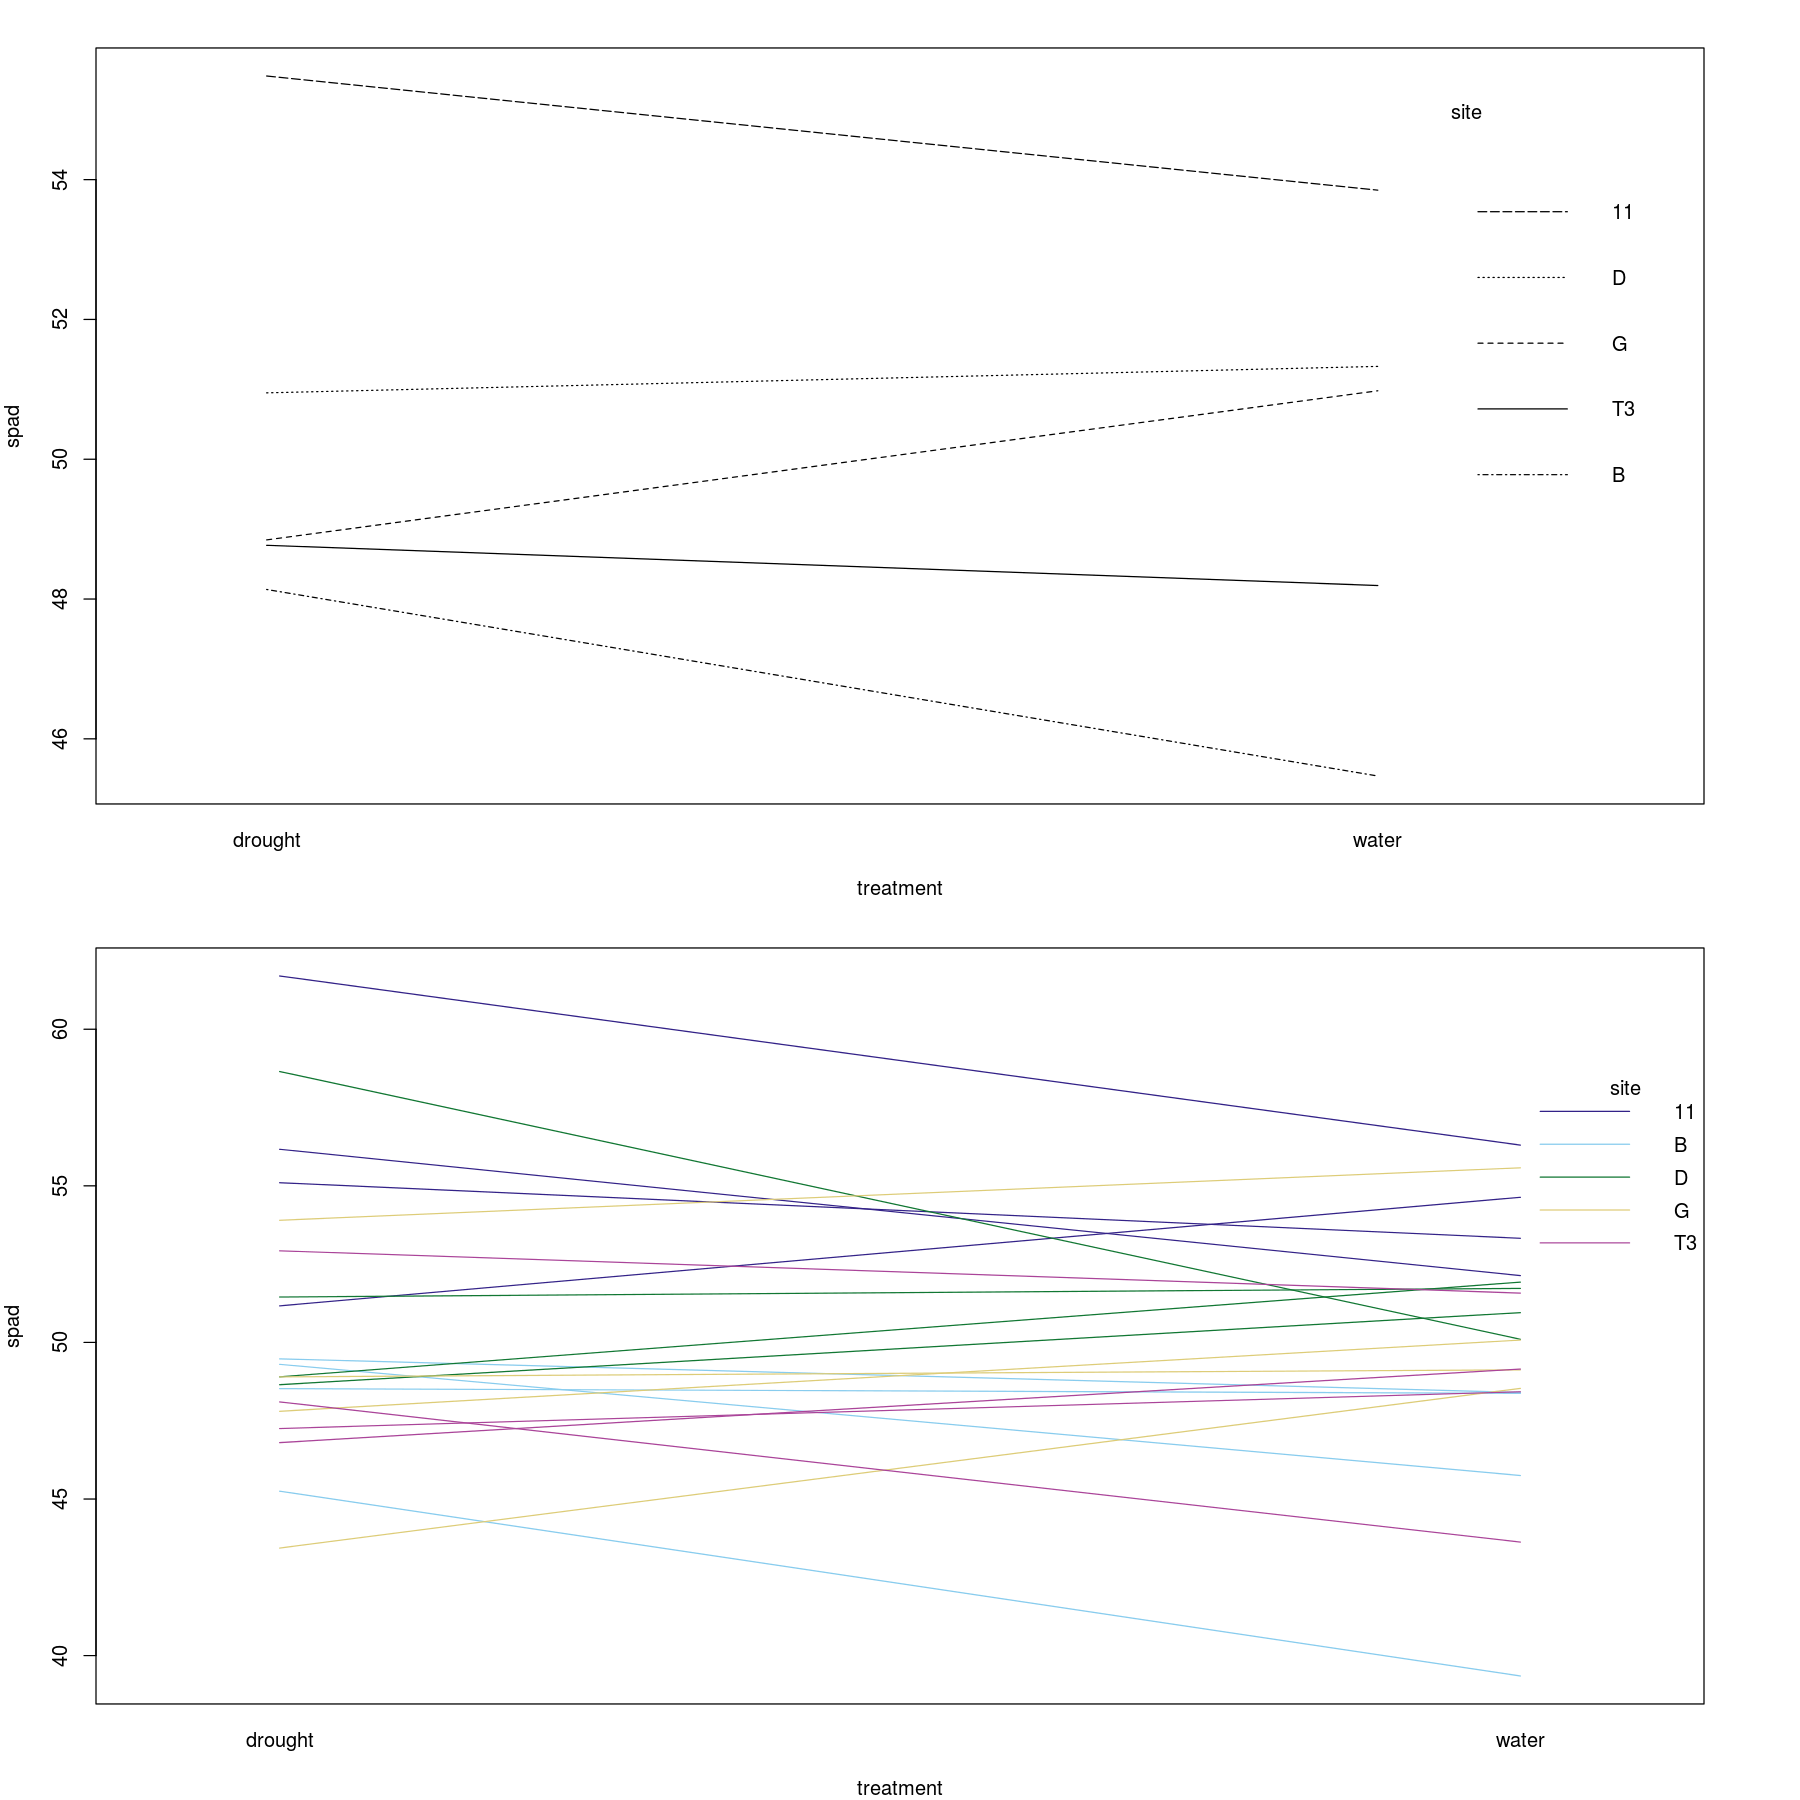

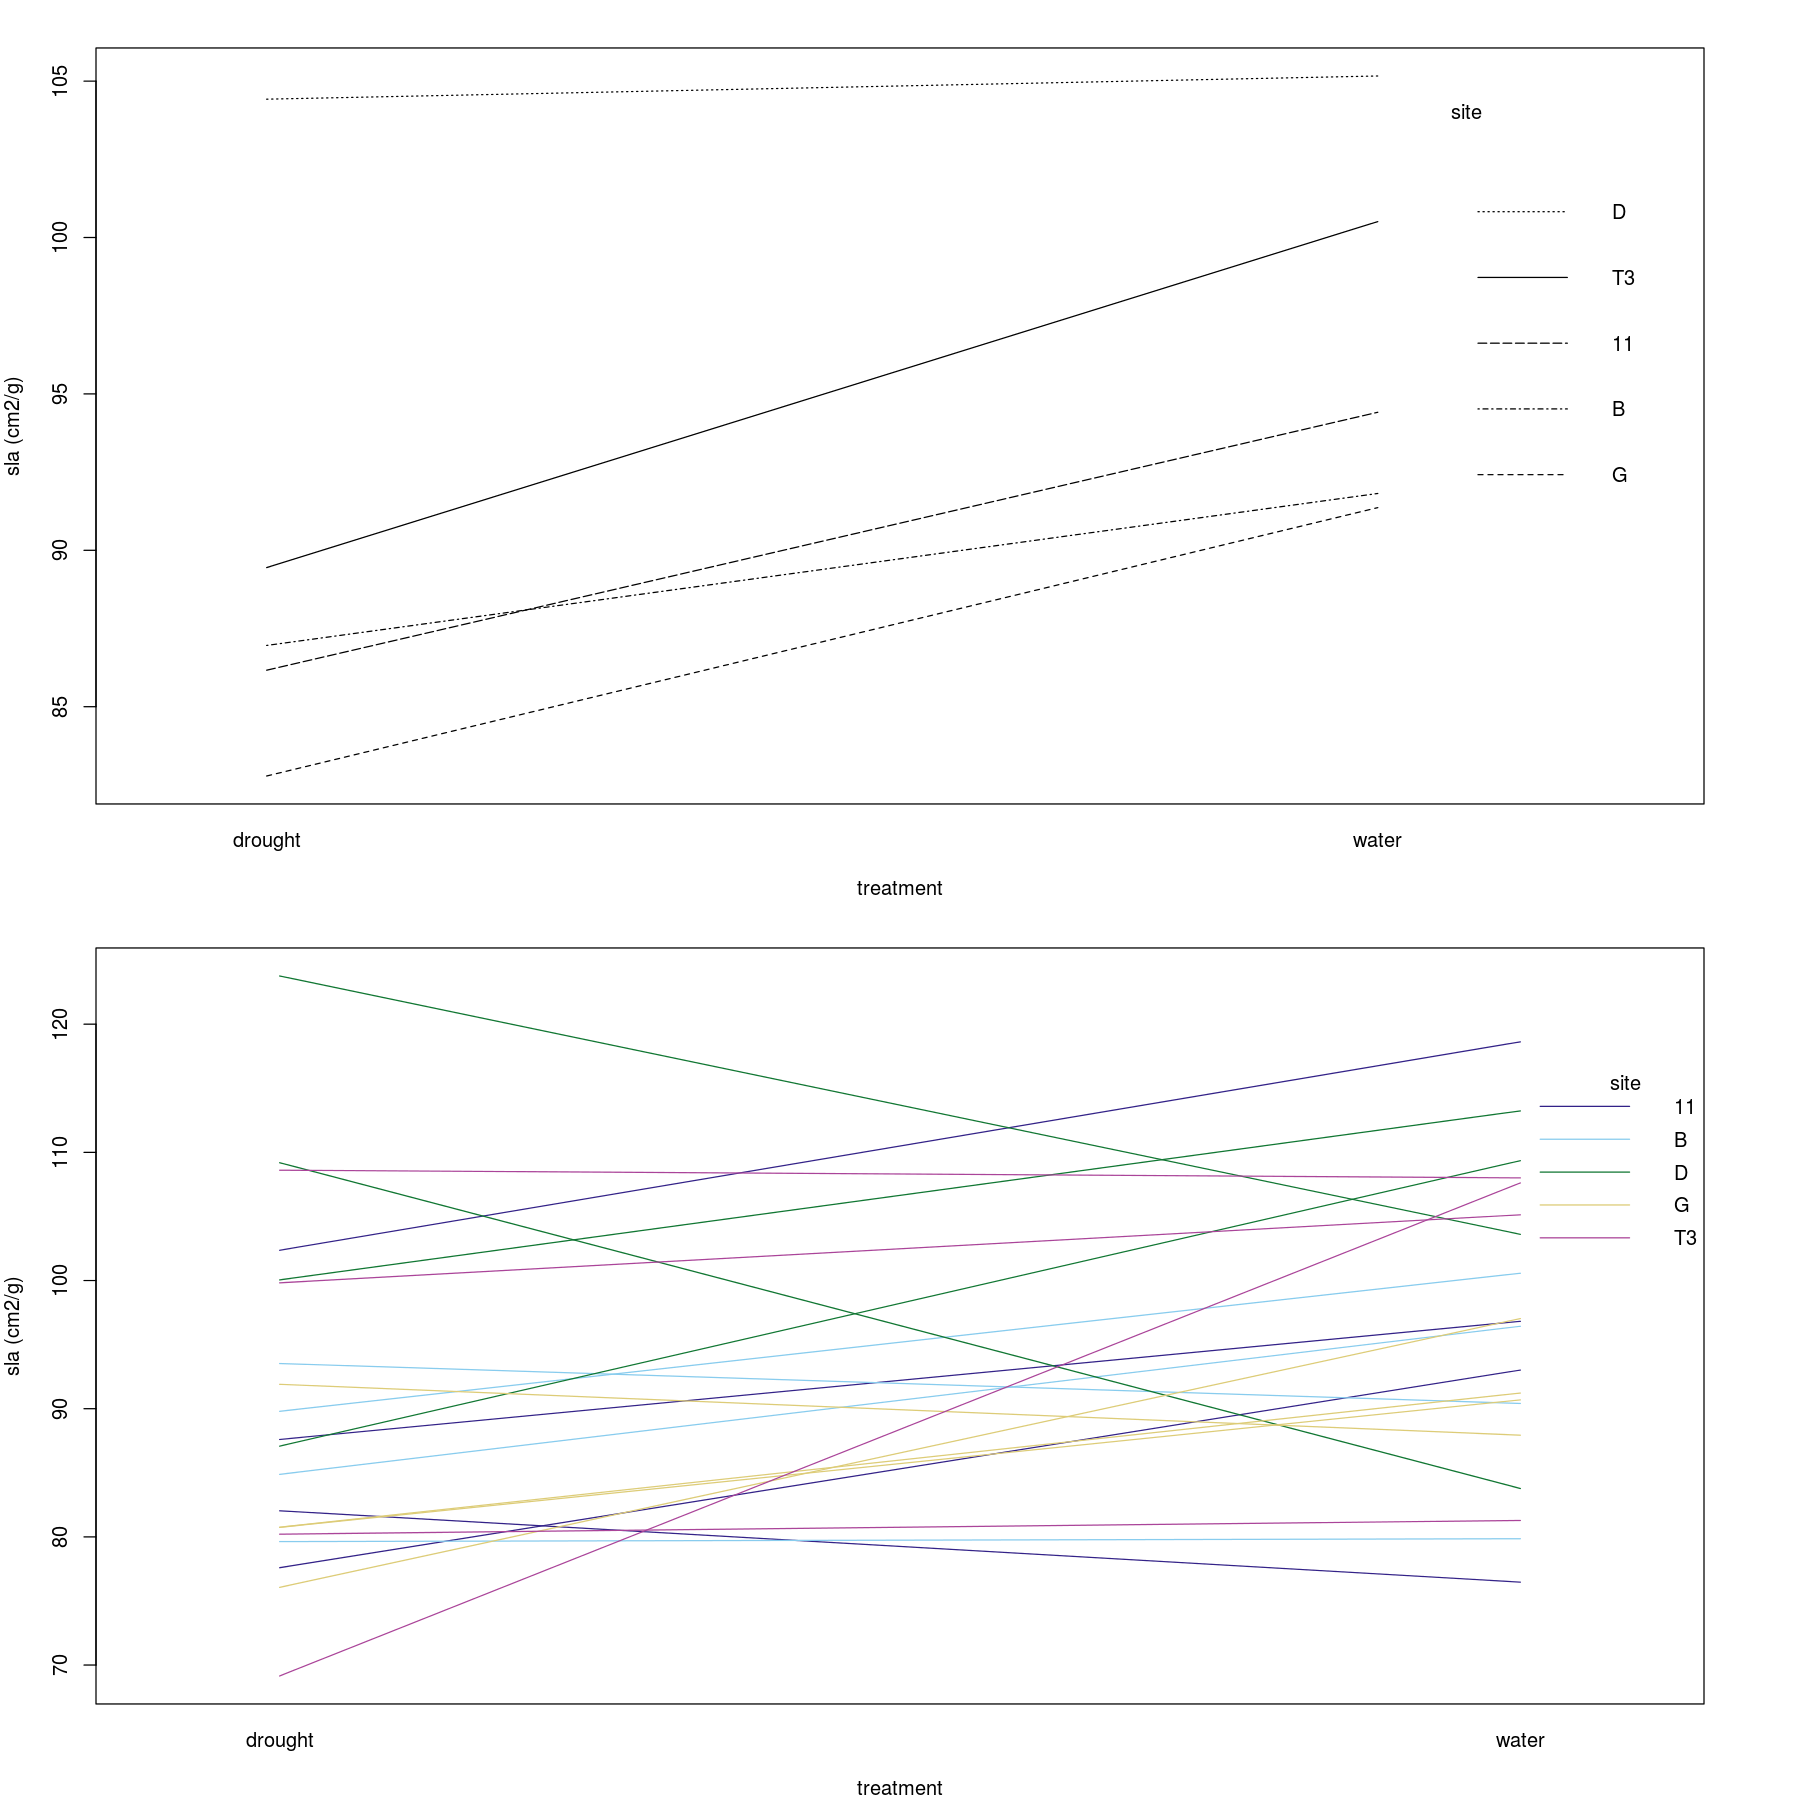

In [8]:
#interaction plots
par(mfrow=c(2,1), mar=c(4,4,2,4))
options(repr.plot.width=15, repr.plot.height=15)

#get colors
#mycols=rainbow(6)
#mycols=c("#332288", "#88CCEE", "#117733", "#DDCC77", "#CC6677", "#AA4499")
mycols=c("#332288", "#88CCEE", "#117733", "#DDCC77", "#AA4499")
#get colors for 4 maternal lines per population
mycols20=c(rep(mycols[1],4),rep(mycols[2],4),rep(mycols[3],4),rep(mycols[4],4),rep(mycols[5],4))

#porometer
interaction.plot(data1$Treatment, data1$Population, data1$porometer,
                 xlab="treatment", trace.label="site", ylab="porometer (mmol/m2s)")
interaction.plot(data1$Treatment, data1$matline, data1$porometer, 
                 xlab="treatment", trace.label="maternal line", ylab="porometer (mmol/m2s)",
                 fixed=T, lty=1, legend=F, col=mycols20)
legend(x=1.98,y=350,title="site",lty=1,bty="n",y.intersp=.5,
       c("11","B","D","G","T3"),col=mycols)

#lw
interaction.plot(data1$Treatment, data1$Population, data1$lw,
                 xlab="treatment", trace.label="site", ylab="length/width ()")
interaction.plot(data1$Treatment, data1$matline, data1$lw, 
                 xlab="treatment", trace.label="maternal line", ylab="length/width ()",
                 fixed=T, lty=1, legend=F, col=mycols20)
legend(x=1.98,y=6,title="site",lty=1,bty="n",y.intersp=.5,
       c("11","B","D","G","T3"),col=mycols)

#spad
interaction.plot(data1$Treatment, data1$Population, data1$spad,
                 xlab="treatment", trace.label="site", ylab="spad")
interaction.plot(data1$Treatment, data1$matline, data1$spad, 
                 xlab="treatment", trace.label="maternal line", ylab="spad",
                 fixed=T, lty=1, legend=F, col=mycols20)
legend(x=1.98,y=60,title="site",lty=1,bty="n",y.intersp=.5,
       c("11","B","D","G","T3"),col=mycols)

#sla
interaction.plot(data1$Treatment, data1$Population, data1$sla,
                 xlab="treatment", trace.label="site", ylab="sla (cm2/g)")
interaction.plot(data1$Treatment, data1$matline, data1$sla, 
                 xlab="treatment", trace.label="maternal line", ylab="sla (cm2/g)",
                 fixed=T, lty=1, legend=F, col=mycols20)
legend(x=1.98,y=145,title="site",lty=1,bty="n",y.intersp=.5,
       c("11","B","D","G","T3"),col=mycols)

#spad2
interaction.plot(data2$Treatment, data2$Population, data2$spad,
                 xlab="treatment", trace.label="site", ylab="spad")
interaction.plot(data2$Treatment, data2$matline, data2$spad, 
                 xlab="treatment", trace.label="maternal line", ylab="spad",
                 fixed=T, lty=1, legend=F, col=mycols20)
legend(x=1.98,y=60,title="site",lty=1,bty="n",y.intersp=.5,
       c("11","B","D","G","T3"),col=mycols)

#sla2
interaction.plot(data2$Treatment, data2$Population, data2$sla,
                 xlab="treatment", trace.label="site", ylab="sla (cm2/g)")
interaction.plot(data2$Treatment, data2$matline, data2$sla, 
                 xlab="treatment", trace.label="maternal line", ylab="sla (cm2/g)",
                 fixed=T, lty=1, legend=F, col=mycols20)
legend(x=1.98,y=120,title="site",lty=1,bty="n",y.intersp=.5,
       c("11","B","D","G","T3"),col=mycols)

In [13]:
#pdf of select interaction plots
pdf("drought_interact.pdf", height=12)
par(mfrow=c(4,1), mar=c(4,4,2,1), oma=c(0,.5,0,0))

#porometer
interaction.plot(data1$Treatment, data1$matline, data1$porometer, 
                 xlab="treatment", trace.label="maternal line", ylab="",
                 fixed=T, lty=1, legend=F, col=mycols20)
mtext(text=expression(paste('stomatal conductance (mmol/(',m ^ 2, 's))'), sep=""), side=2, cex=.7, line=2.5)
legend(x=2,y=375,title="site",lty=1,bty="n",y.intersp=.8,
       c("11","B","D","G","T3"),col=mycols)

#lw
interaction.plot(data1$Treatment, data1$matline, data1$lw, 
                 xlab="treatment", trace.label="maternal line", ylab="length to width ratio",
                 fixed=T, lty=1, legend=F, col=mycols20)

#spad2
interaction.plot(data2$Treatment, data2$matline, data2$spad, 
                 xlab="treatment", trace.label="maternal line", ylab="SPAD index",
                 fixed=T, lty=1, legend=F, col=mycols20)

#sla2
interaction.plot(data2$Treatment, data2$matline, data2$sla, 
                 xlab="treatment", trace.label="maternal line", ylab="",
                 fixed=T, lty=1, legend=F, col=mycols20)
mtext(text=expression(paste('SLA (',cm^2,'/g)',sep="")), side=2, cex=.7, line=2.5)

dev.off()

pdf 
  2

# initial linear mixed model (lme4)

In [ ]:
library(lme4)
library(lmerTest)

In [ ]:
print("porometer, population")
lmmodel=lmer(porometer ~ Treatment * Population + (1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
anova(lmmodel)
vars[,c("grp","percent_explained")]

print("porometer, maternal line")
lmmodel=lmer(porometer ~ Treatment * matline + (1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
anova(lmmodel)
vars[,c("grp","percent_explained")]

print("lw, population")
lmmodel=lmer(lw ~ Treatment * Population + (1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
anova(lmmodel)
vars[,c("grp","percent_explained")]

print("lw, maternal line")
lmmodel=lmer(lw ~ Treatment * matline + (1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
anova(lmmodel)
vars[,c("grp","percent_explained")]

print("spad, population")
lmmodel=lmer(spad ~ Treatment * Population + (1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
anova(lmmodel)
vars[,c("grp","percent_explained")]

print("spad, maternal line")
lmmodel=lmer(spad ~ Treatment * matline + (1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
anova(lmmodel)
vars[,c("grp","percent_explained")]

print("sla, population")
lmmodel=lmer(sla ~ Treatment * Population + (1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
anova(lmmodel)
vars[,c("grp","percent_explained")]

print("sla, maternal line")
lmmodel=lmer(sla ~ Treatment * matline + (1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
anova(lmmodel)
vars[,c("grp","percent_explained")]

no interaction for any model; pair (row:column) and Block did explain non-trivial amount of variation

# final linear mixed model (lme4)

In [ ]:
print("porometer")
lmmodel=lmer(porometer ~ Treatment + Population/matline + (1|Block) + (1|row:column), data=data1)
anova(lmmodel)
#variance component model
lmmodel=lmer(porometer ~ (1|Population/matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("porometer, population")
lmmodel=lmer(porometer ~ Treatment + Population + (1|Block) + (1|row:column), data=data1)
anova(lmmodel)
#variance component model
lmmodel=lmer(porometer ~ (1|Population) + (1|Treatment) +(1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("porometer, maternal line")
lmmodel=lmer(porometer ~ Treatment + matline + (1|Block) + (1|row:column), data=data1)
anova(lmmodel)
#variance component model
lmmodel=lmer(porometer ~ (1|matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

In [ ]:
print("porometer")
lmmodel=lmer(porometer ~ Treatment + Population/matline + (1|Block) + (1|row:column), data=data1)
anova(lmmodel)
#variance component model
lmmodel=lmer(porometer ~ (1|Population/matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("porometer, population")
lmmodel=lmer(porometer ~ Treatment + Population + (1|Block) + (1|row:column), data=data1)
anova(lmmodel)
#variance component model
lmmodel=lmer(porometer ~ (1|Population) + (1|Treatment) +(1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("porometer, maternal line")
lmmodel=lmer(porometer ~ Treatment + matline + (1|Block) + (1|row:column), data=data1)
anova(lmmodel)
#variance component model
lmmodel=lmer(porometer ~ (1|matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]


print("lw")
lmmodel=lmer(lw ~ Treatment + Population/matline + (1|Block) + (1|row:column), data=data1)
anova(lmmodel)
#variance component model
lmmodel=lmer(lw ~ (1|Population/matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("lw, population")
lmmodel=lmer(lw ~ Treatment + Population + (1|Block) + (1|row:column), data=data1)
anova(lmmodel)
#variance component model
lmmodel=lmer(lw ~ (1|Population) + (1|Treatment) +(1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("lw, maternal line")
lmmodel=lmer(lw ~ Treatment + matline + (1|Block) + (1|row:column), data=data1)
anova(lmmodel)
#variance component model
lmmodel=lmer(lw ~ (1|matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data1)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]


print("spad")
lmmodel=lmer(spad ~ Treatment + Population/matline + (1|Block) + (1|row:column), data=data2)
anova(lmmodel)
#variance component model
lmmodel=lmer(spad ~ (1|Population/matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("spad, population")
lmmodel=lmer(spad ~ Treatment + Population + (1|Block) + (1|row:column), data=data2)
anova(lmmodel)
#variance component model
lmmodel=lmer(spad ~ (1|Population) + (1|Treatment) +(1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("spad, maternal line")
lmmodel=lmer(spad ~ Treatment + matline + (1|Block) + (1|row:column), data=data2)
anova(lmmodel)
#variance component model
lmmodel=lmer(spad ~ (1|matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("sla, population")
lmmodel=lmer(sla ~ Treatment + Population/matline + (1|Block) + (1|row:column), data=data2)
anova(lmmodel)
#variance component model
lmmodel=lmer(sla ~ (1|Population/matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("sla, population")
lmmodel=lmer(sla ~ Treatment + Population + (1|Block) + (1|row:column), data=data2)
anova(lmmodel)
#variance component model
lmmodel=lmer(sla ~ (1|Population) + (1|Treatment) +(1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

print("sla, maternal line")
lmmodel=lmer(sla ~ Treatment + matline + (1|Block) + (1|row:column), data=data2)
anova(lmmodel)
#variance component model
lmmodel=lmer(sla ~ (1|matline) + (1|Treatment) +(1|Block) + (1|row:column), data=data2)
vars=as.data.frame(VarCorr(lmmodel),comp="Variance")
vars$percent_explained=vars$vcov/sum(vars$vcov)*100
vars[,c("grp","percent_explained")]

# paired analysis

In [ ]:
t.test(subset(data1, Treatment=="Water")$porometer, subset(data1, Treatment=="Drought")$porometer, paired=T)

In [ ]:
#porometer paired ((water-drought)/water)
paired=subset(data1, Treatment=="Water")[c("row","column","Block","Population","matline")]
paired$porometer=(subset(data1, Treatment=="Water")$porometer-subset(data1, Treatment=="Drought")$porometer)/subset(data1, Treatment=="Water")$porometer
par(mfrow=c(1,4), mar=c(4,4,2,1))
options(repr.plot.width=10, repr.plot.height=3)
dotchart(paired$porometer, groups=paired$matline, xlab="porometer (mmol/m2s)", ylab="maternal line", pch=20)
qqnorm(paired$porometer)
qqline(paired$porometer)
boxplot(porometer ~ Population, data=paired, xlab="population",ylab="porometer (mmol/m2s)")
boxplot(porometer ~ matline, data=paired, xlab="maternal line",ylab="porometer (mmol/m2s)")

In [ ]:
#spad paired ((water-drought)/water)
paired=subset(data2, Treatment=="Water")[c("row","column","Block","Population","matline")]
paired$spad=(subset(data2, Treatment=="Water")$spad-subset(data2, Treatment=="Drought")$spad)/subset(data2, Treatment=="Water")$spad
par(mfrow=c(1,4), mar=c(4,4,2,1))
options(repr.plot.width=10, repr.plot.height=3)
dotchart(paired$spad, groups=paired$matline, xlab="spad", ylab="maternal line", pch=20)
qqnorm(paired$spad)
qqline(paired$spad)
boxplot(spad ~ Population, data=paired, xlab="population",ylab="spad")
boxplot(spad ~ matline, data=paired, xlab="maternal line",ylab="spad")

#spad paired ((water-drought)/water)
paired$sla=(subset(data2, Treatment=="Water")$sla-subset(data2, Treatment=="Drought")$sla)/subset(data2, Treatment=="Water")$sla
par(mfrow=c(1,4), mar=c(4,4,2,1))
options(repr.plot.width=10, repr.plot.height=3)
dotchart(paired$sla, groups=paired$matline, xlab="sla (cm2/g)", ylab="maternal line", pch=20)
qqnorm(paired$sla)
qqline(paired$sla)
boxplot(sla ~ Population, data=paired, xlab="population",ylab="sla (cm2/g)")
boxplot(sla ~ matline, data=paired, xlab="maternal line",ylab="sla (cm2/g)")

In [ ]:
#simple paired t test
#get two data subsets, they are ordered, so should match properly
watered=data2[which(data2$Treatment=='Water'),]
drought=data2[which(data2$Treatment=='Drought'),]
t.test(watered$spad, drought$spad, paired=T)
t.test(watered$sla, drought$sla, paired=T)
t.test(watered$weigh, drought$weight, paired=T)
t.test(watered$area, drought$area, paired=T)